In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
ticker = 'MSFT'
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

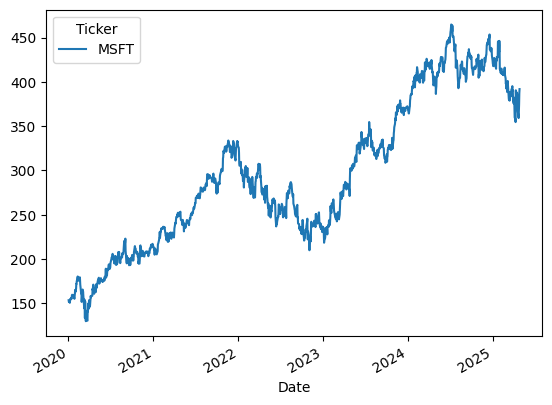

In [40]:
df.Close.plot()

In [41]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.692115
2020-01-03,-1.714910
2020-01-06,-1.710237
2020-01-07,-1.726763
2020-01-08,-1.698155
...,...
2025-04-21,0.765104
2025-04-22,0.857042
2025-04-23,0.947428


In [42]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.float32).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.float32).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.float32).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.float32).to(device)



In [43]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [44]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [45]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [46]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0 0.7030143737792969
25 0.014254588633775711
50 0.0058110561221838
75 0.00493700010702014
100 0.004681004676967859
125 0.004475015681236982
150 0.00428308779373765
175 0.004102441947907209


In [47]:
model.eval()
y_test_pred = model(X_test)

# Now, AFTER prediction:

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [48]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [49]:
train_rmse

5.258513450622559

In [50]:
test_rmse

8.967497825622559

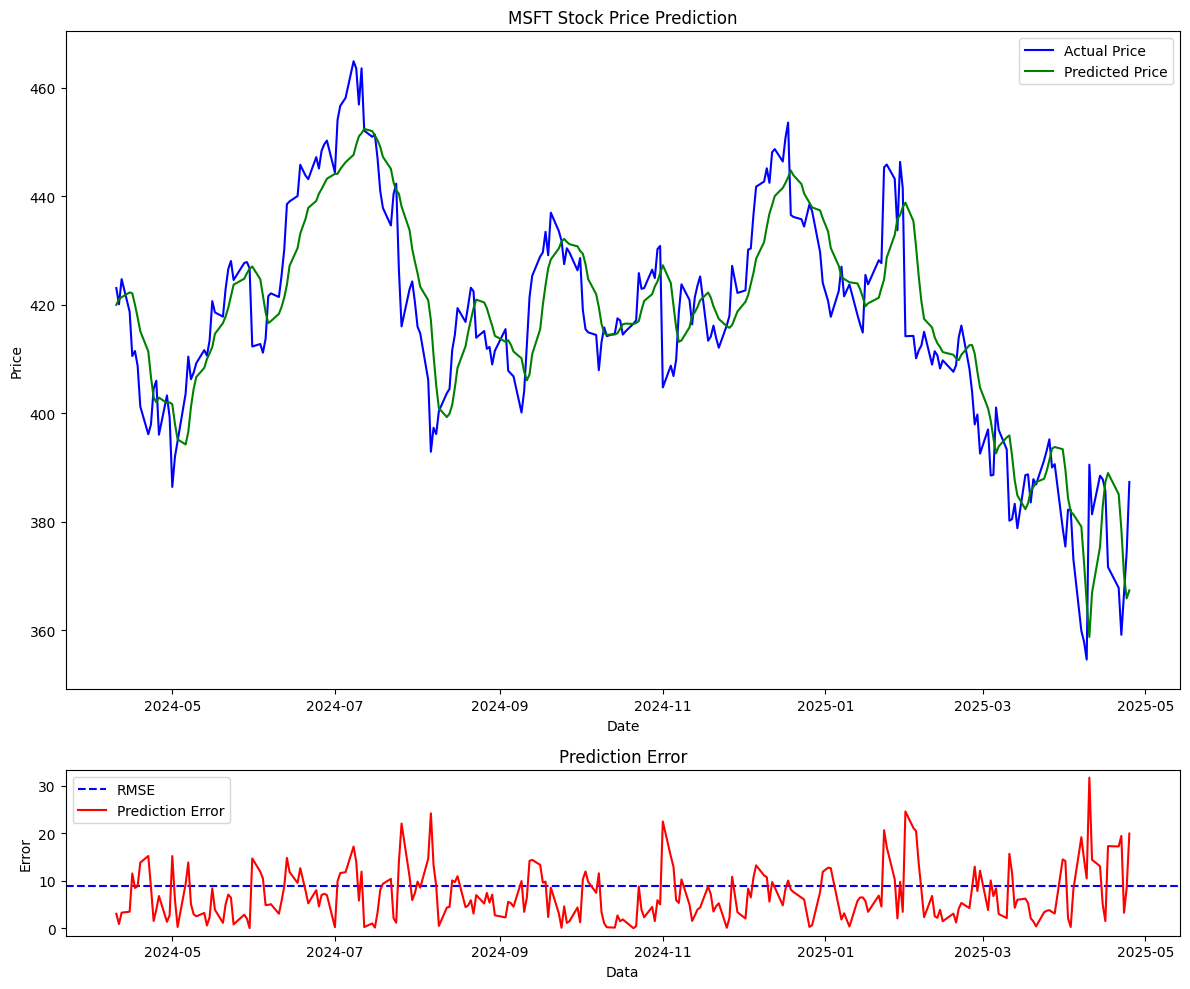

In [51]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Data')
plt.ylabel('Error')

plt.tight_layout()
plt.show()